# 3.5 Retrieval 효율 개선을 위한 전처리

<div style="text-align: right"> Initial issue : 2022.09.30 </div>
<div style="text-align: right"> last update : 2022.09.30 </div>

할일 정리   
1. 문서의 내용을 읽는다.  
2. 문서를 쪼갠다.  
- 토큰수 초과로 답변을 생성하지 못할 수 있고
- 문서가 길면(입력이 길면) 답변을 생성하지 못할 수 있다. 오래걸린다.  
3. 임베딩 -> 벡터 데이터베이스에 저장
4. 질문이 있을 때, 벡터 데이터베이스에 유사도 검색
5. 유사도 검색으로 가져온 문서를 LLM에 질문과 같이 전달

여기서는 문서 내용을 읽기 위해 Docx2txtLoader를 사용한다.  
- https://python.langchain.com/docs/integrations/document_loaders/microsoft_word/

- https://python.langchain.com/docs/integrations/vectorstores/pinecone/

- https://app.pinecone.io/

그런데 지금의 llm의 답변은 잘못되었다.  
답변은 55조에 있는데 잘못 받아오고 있는 것이다.

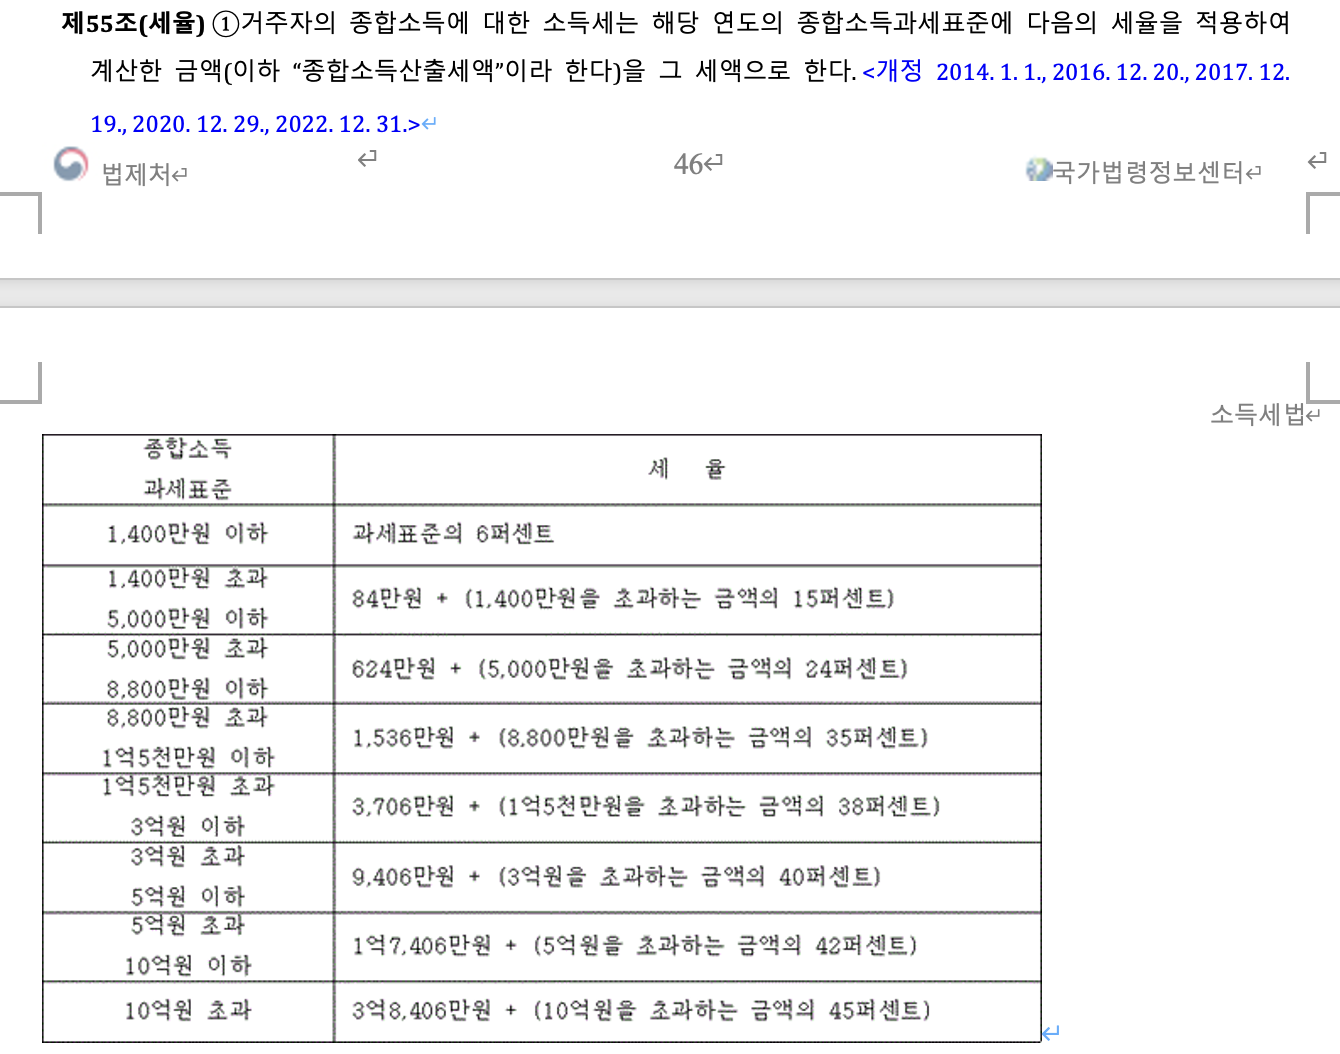

- retriever.invoke(query) 명령을 실행해보면 답변을 제대로 못가져옴
- docx2textloader가 표를 파싱하지 못하기 때문이다.

이미지를 표로 대체한 문서로 tax-table-index를 만들어서 진행해보자.

### 1. 패키지 설치

In [5]:
# %pip install --upgrade --quiet  docx2txt langchain-community==0.2.16
%pip install --upgrade --quiet langchain-pinecone==0.1.3 langchain-community==0.2.16

Note: you may need to restart the kernel to use updated packages.


In [6]:
from dotenv import load_dotenv
load_dotenv()

True

# 2. Knowledge Base 구성을 위한 데이터 생성

- [RecursiveCharacterTextSplitter](https://python.langchain.com/v0.2/docs/how_to/recursive_text_splitter/)를 활용한 데이터 chunking
    - split 된 데이터 chunk를 Large Language Model(LLM)에게 전달하면 토큰 절약 가능
    - 비용 감소와 답변 생성시간 감소의 효과
    - LangChain에서 다양한 [TextSplitter](https://python.langchain.com/v0.2/docs/how_to/#text-splitters)들을 제공
- `chunk_size` 는 split 된 chunk의 최대 크기
- `chunk_overlap`은 앞 뒤로 나뉘어진 chunk들이 얼마나 겹쳐도 되는지 지정

In [7]:
from langchain_community.document_loaders import Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
)

loader = Docx2txtLoader('./tax_with_table.docx')
document_list = loader.load_and_split(text_splitter=text_splitter)

In [8]:
len(document_list)

225

In [9]:
# 임베딩 진행
from langchain_openai import OpenAIEmbeddings

# OpenAI에서 제공하는 Embedding Model을 활용해서 `chunk`를 vector화
embedding = OpenAIEmbeddings(model='text-embedding-3-large') # 디펄트 대신 성능 좋은 것으로...

In [10]:
# import os
# pinecone_api_key = os.environ.get("PINECONE_API_KEY")

# from pinecone import Pinecone

# pc = Pinecone(api_key=pinecone_api_key)

In [11]:
#%pip install -q langchain-chroma

In [12]:
# from langchain_chroma import Chroma

# # 데이터를 처음 저장할 때 
# # database = Chroma.from_documents(
# #     documents=document_list, 
# #     embedding=embedding, 
# #     collection_name='chroma-tax',# 테이블 이름
# #     persist_directory="./chroma" # 임베딩 결과를 저장할 경로
# #     )

# # 이미 저장된 데이터를 사용할 때 
# database = Chroma(collection_name='chroma-tax', persist_directory="./chroma", embedding_function=embedding)

In [13]:
import os 
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore

index_name = "tax-table-index"
pinecone_api_key = os.environ.get("PINECONE_API_KEY")

database = PineconeVectorStore.from_documents(
    documents=document_list,
    embedding=embedding,
    index_name=index_name,
)


/Users/sguys99/anaconda3/envs/rag/lib/python3.11/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# 3. 답변 생성을 위한 Retrieval

- 유사도 검색(`similarity_search()`)를 활용해서 가져옴

In [15]:
# 테스트
query = "연봉 5천만원인 직장인의 소득세는 얼마인가요?"
# retrieved_docs = database.similarity_search(query, k=5)

In [16]:
retriever = database.as_retriever()
retriever.invoke(query) # 테스트

[Document(metadata={'source': './tax_with_table.docx'}, page_content='나. 그 밖의 배당소득에 대해서는 100분의 14\n\n3. 원천징수대상 사업소득에 대해서는 100분의 3. 다만, 외국인 직업운동가가 한국표준산업분류에 따른 스포츠 클럽 운영업 중 프로스포츠구단과의 계약(계약기간이 3년 이하인 경우로 한정한다)에 따라 용역을 제공하고 받는 소득에 대해서는 100분의 20으로 한다.\n\n4. 근로소득에 대해서는 기본세율. 다만, 일용근로자의 근로소득에 대해서는 100분의 6으로 한다.\n\n5. 공적연금소득에 대해서는 기본세율\n\n5의2.제20조의3제1항제2호나목 및 다목에 따른 연금계좌 납입액이나 운용실적에 따라 증가된 금액을 연금수령한 연금소득에 대해서는 다음 각 목의 구분에 따른 세율. 이 경우 각 목의 요건을 동시에 충족하는 때에는 낮은 세율을 적용한다.\n\n가. 연금소득자의 나이에 따른 다음의 세율\n\n\n\n나. 삭제<2014. 12. 23.>\n\n다. 사망할 때까지 연금수령하는 대통령령으로 정하는 종신계약에 따라 받는 연금소득에 대해서는 100분의 4\n\n5의3. 제20조의3제1항제2호가목에 따라 퇴직소득을 연금수령하는 연금소득에 대해서는 다음 각 목의 구분에 따른 세율. 이 경우 연금 실제 수령연차 및 연금외수령 원천징수세율의 구체적인 내용은 대통령령으로 정한다.\n\n가. 연금 실제 수령연차가 10년 이하인 경우: 연금외수령 원천징수세율의 100분의 70\n\n나. 연금 실제 수령연차가 10년을 초과하는 경우: 연금외수령 원천징수세율의 100분의 60\n\n6. 기타소득에 대해서는 다음에 규정하는 세율. 다만, 제8호를 적용받는 경우는 제외한다.\n\n가. 제14조제3항제8호라목 및 마목에 해당하는 소득금액이 3억원을 초과하는 경우 그 초과하는 분에 대해서는 100분의 30\n\n나. 제21조제1항제18호 및 제21호에 따른 기타소득에 대해서는 100분의 15\n\n다. 삭제<

- 또 못가져왔다.
- 표를 여전히 인식하지 못하기 때문이다.

# 4. Augmentation을 위한 Prompt 활용

- Retrieval된 데이터는 LangChain에서 제공하는 프롬프트(`"rlm/rag-prompt"`) 사용

In [17]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [18]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

In [19]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [20]:
print(prompt[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


# 5. 답변 생성

- [RetrievalQA](https://docs.smith.langchain.com/old/cookbook/hub-examples/retrieval-qa-chain)를 통해 LLM에 전달
    - `RetrievalQA`는 [create_retrieval_chain](https://python.langchain.com/v0.2/docs/how_to/qa_sources/#using-create_retrieval_chain)으로 대체됨
    - 실제 ChatBot 구현 시 `create_retrieval_chain`으로 변경하는 과정을 볼 수 있음

In [21]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm, 
    retriever=database.as_retriever(),
    chain_type_kwargs={"prompt": prompt}
)

In [22]:
qa_chain

RetrievalQA(combine_documents_chain=StuffDocumentsChain(llm_chain=LLMChain(prompt=ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]), llm=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x141653490>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x141617ad0>, root_client=<openai.OpenAI object at 0x146dc7490>, root_async_client=<openai.AsyncOpenAI object at 0x1569c08d0>, mod

In [23]:
ai_message = qa_chain({"query": query})

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_48103/3455095564.py:1: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  ai_message = qa_chain({"query": query})


In [24]:
# 강의에서는 위처럼 진행하지만 업데이트된 LangChain 문법은 `.invoke()` 활용을 권장
ai_message = qa_chain.invoke({"query": query})

In [25]:
ai_message

{'query': '연봉 5천만원인 직장인의 소득세는 얼마인가요?',
 'result': '연봉 5천만원인 직장인의 소득세는 기본세율이 적용됩니다. 소득세 기본세율은 과세표준에 따라 차등 적용되며, 이를 계산하려면 정확한 과세표준과 해당하는 세율을 알아야 합니다. 구체적인 금액 산출은 제공된 정보만으로는 어렵습니다.'}

- ? 프롬프트에 query 자리가 없는데 입력되는 이유?

## 표를 마크다운으로 바꾼 문서로 다시 진행해보자.